# Modeling 4: Neural Network using SMOTE

- **Author**: Dan O'Connor
- **Notebook**: 7 of 9

In this notebook I will be addressing the imbalanced classes by using Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples from minority classes to balance the distribution of the target variable. I will be applying SMOTE then retraining a NN.

Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from google.colab import drive #colab

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


Load in required data.

In [2]:
subset_model_df = pd.read_csv('Data/subset_model_df.csv')

In [51]:
accuracy_df = pd.read_csv('Data/accuracy_df3.csv', index_col='Model')

In [52]:
scores_df = pd.read_csv('Data/scores_df3.csv', index_col = 'Genres')

I chose to use a NN with the SMOTE data because the NN has been my best performing model thus far. Likely the proportions between various models would remain the same with SMOTE, therefore I am only testing on one model.

In [7]:
accuracy_df


,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,NaN
Logistic Regression,0.66,0.66
KNN,0.62,0.63
Random Forest,0.64,0.64
Decision Tree,0.47,0.52
Neural Net,0.65,0.67
SMOTE Neural Net,NaN,NaN


There is a very delicate process for applying SMOTE with scaling and splitting into training, val and testing sets. I will walk through the steps below.

Split target and dependent variables.

In [4]:
X = subset_model_df.drop(columns='genre_top')
y = subset_model_df['genre_top']

In [10]:
from my_functions import get_class_metrics 

Label encode the target variable.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Encoder object
label_encoder = LabelEncoder()

# Fit the encoder on y
label_encoder.fit(y)

# Transform
y_encoded = label_encoder.transform(y)

First I split into train and test.

In [6]:
from sklearn.model_selection import train_test_split
#split into train test
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.25, stratify=y_encoded,random_state=1)

Further split into training subset and a validation set, from the train set. On this second split I am careful to stratify on y train, which was previous stratified on y_encoded. This ensures the same distribution of classes in both the train and validation.

In [8]:
#further split into val and train subset
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train,y_train, test_size=0.25, stratify=y_train,random_state=1)

Next I instaniate the standard scaler and fit and transform only to the X_train subset.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #instaniate the object
X_train_subset_scaled = scaler.fit_transform(X_train_subset) #fit only to train subset

Then I apply SMOTE to the X_train subset and the y_train subset.

In [11]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42) #instaniate SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_subset_scaled, y_train_subset) #fit to the scaled training subsets

Fit the x val and test to the scaler that was fit on the subset before SMOTE.

In [13]:
X_val_scaled = scaler.transform(X_val) #transform val
X_test_scaled = scaler.transform(X_test) #transform test

Below shows a graphic of what SMOTE accomplishes. It balances the classes in the training data, synthetically. The majority class, rock, stays the same but the smaller classes get synthetic samples added.

In [14]:
from collections import Counter

#new class distribution after SMOTE
counter = Counter(y_train_smote) #count tthe y train
print("New class distribution after applying SMOTE:", counter)

New class distribution after applying SMOTE: Counter({5: 7978, 2: 7978, 1: 7978, 8: 7978, 4: 7978, 3: 7978, 6: 7978, 7: 7978, 0: 7978})


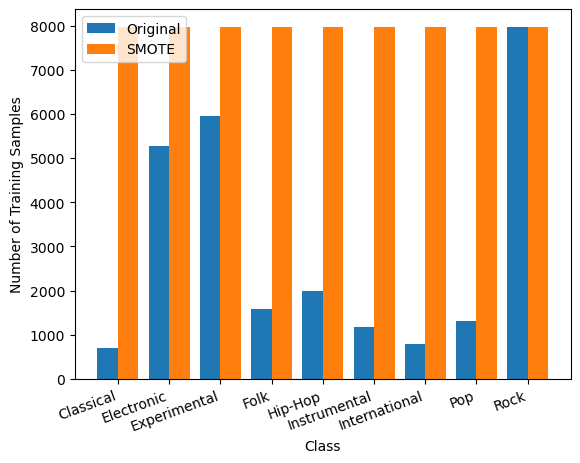

In [17]:
#Class labels
class_labels = {0: 'Classical', 1: 'Electronic', 2: 'Experimental', 3: 'Folk', 4: 'Hip-Hop', 
                5: 'Instrumental', 6: 'International', 7: 'Pop', 8: 'Rock'}

#replace the class numbers with the class labels
labels = [class_labels[label] for label in np.unique(y_train)]

# Count the number of instances for each class (orig dataset)
original_counts = [np.sum(y_train_subset == label) for label in np.unique(y_train)]

# Count the number of instances for each class (SMOTE)
resampled_counts = [np.sum(y_train_smote == label) for label in np.unique(y_train_smote)]

# Plot original vs smote
fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)) - 0.2, original_counts, width=0.4, label='Original')
ax.bar(np.arange(len(labels)) + 0.2, resampled_counts, width=0.4, label='SMOTE')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Training Samples')
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.legend()
plt.savefig('SMOTE.png')
plt.show()

## Nueral Network

### Baseline

I will follow an identical process for training and optimizing the NN as I did in notebook 6. For the baseline I start with a very simple NN but train it on the SMOTE data. The model is still evaluated on the same test data as before.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

tf.random.set_seed(42)

# model
model = keras.Sequential() #sequential
model.add(layers.Dense(64, activation='relu', input_dim=X_train_smote.shape[1])) #input dim num of cols in features
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax')) #ouput dim num oof classses

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train 
model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, verbose=3) #train on smote scaled data

# Evaluate 
loss, baseline_smote_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", baseline_smote_nn_accuracy)
# Generate predictions 
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
baseline_smote_nn_class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
372/372 [==============================] - 1s 2ms/step - loss: 3.0472 - accuracy: 0.6047
Accuracy: 0.6047274470329285
372/372 [==============================] - 1s 1ms/step


In [62]:
accuracy_df.loc['SMOTE Neural Net', 'Baseline Accuracy'] = round(baseline_smote_nn_accuracy,2)
print('Baseline Accuracy: ', baseline_smote_nn_accuracy)

Baseline Accuracy:  0.6047274470329285


In [54]:
get_class_metrics(baseline_smote_nn_class_report,'baseline_smote_nn',scores_df)


### Optimized

I used the train, val, and test splits I made further up in the notebook to tune the hyperparameters.

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report



tf.random.set_seed(42)



#  layers
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1])) #128 neurons
model.add(layers.Dense(64, activation='relu')) #64 neurons
model.add(layers.Dense(32, activation='relu')) #32 neurons
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax')) #9 nerons

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train_smote, y_train_smote, 
                    epochs=25, 
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val)) #validation
 
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", accuracy)

# Generate predictions on the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
372/372 [==============================] - 1s 2ms/step - loss: 3.0440 - accuracy: 0.6291
Accuracy: 0.6291217803955078
372/372 [==============================] - 1s 2ms/step


Immediately, the model overfits. I will add dropout layers to better generalize.

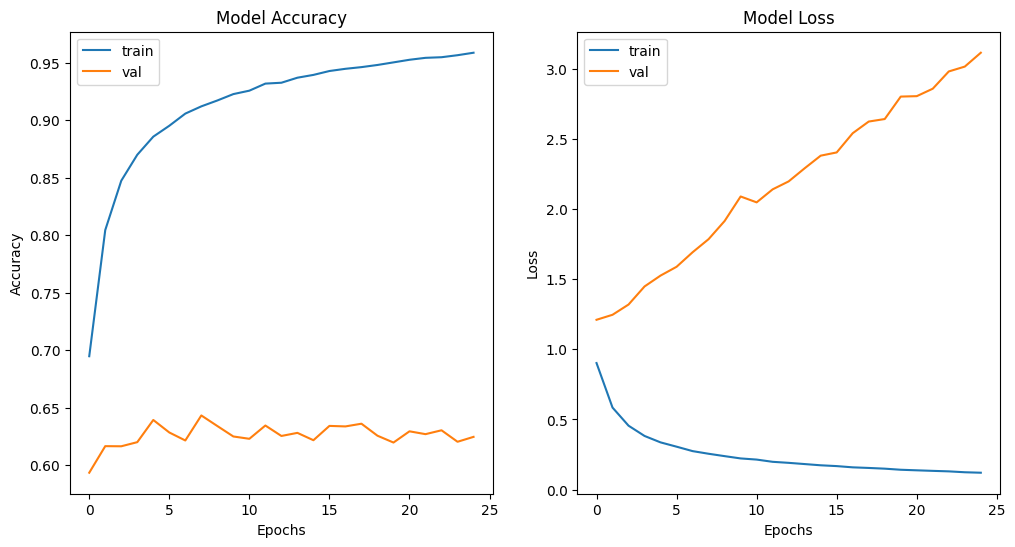

In [23]:
#plot the accuracy and losss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [24]:

tf.random.set_seed(42)



#  layers
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train 
history = model.fit(X_train_smote, y_train_smote, 
                    epochs=25, 
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val))

# Evaluate 
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", accuracy)

# Generate predictions on the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
372/372 [==============================] - 1s 3ms/step - loss: 1.1818 - accuracy: 0.6179
Accuracy: 0.6179340481758118
372/372 [==============================] - 1s 2ms/step


The model is better generalizing with the drop out layers, so now I will increase the epochs to try to find the divergence between the training and validation sets.

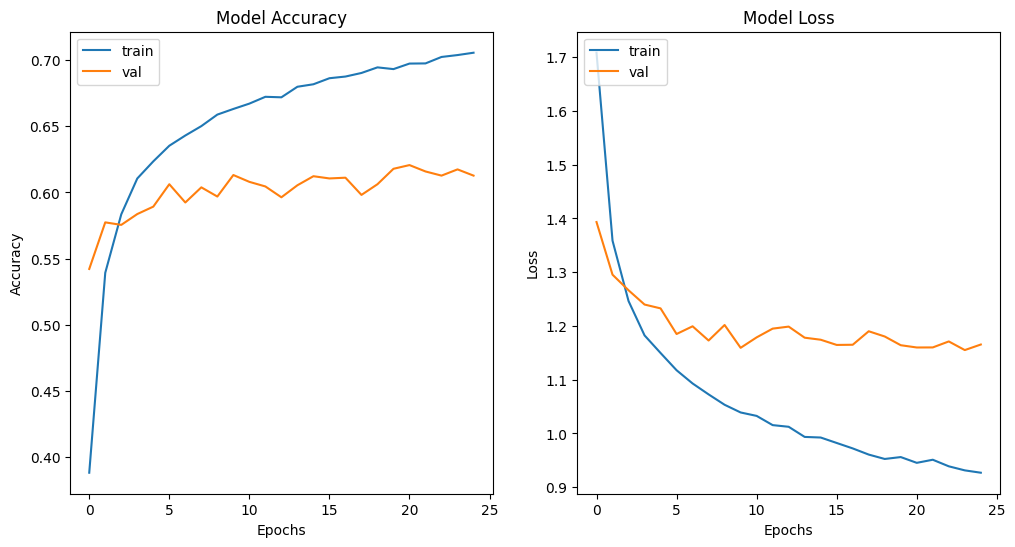

In [25]:
# plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [28]:

tf.random.set_seed(42)



# Same architecture as before
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train 
history = model.fit(X_train_smote, y_train_smote, 
                    epochs=150, 
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val))

# Evaluate 
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", accuracy)

# Generate predictions on the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

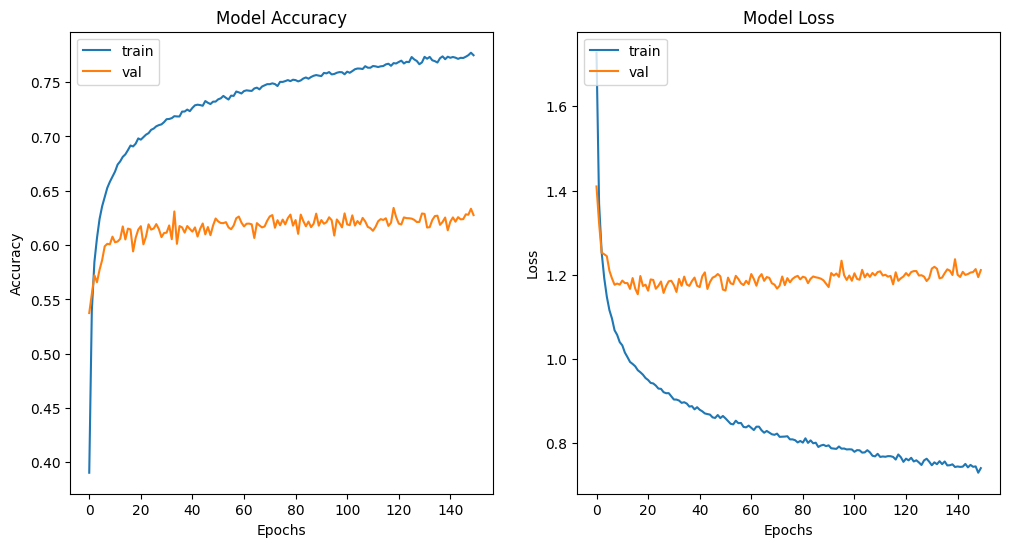

In [29]:
#plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

I chose 120 epochs as the optimal number. I ran the model and saved it to access later.

In [29]:


#same architecture as before
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train_subset.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 120 epochs
history = model.fit(X_train_smote, y_train_smote, 
                    epochs=120, 
                    batch_size=32, 
                    )

# Evaluate
loss, final_smote_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", final_smote_nn_accuracy)

# Generate predictions on the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
final_smote_nn_class_report = classification_report(y_test, y_pred, output_dict=True)
#save model
model.save('final_smote_nn_model.h5')

Epoch 1/100
2244/2244 [==============================] - 15s 6ms/step - loss: 1.6759 - accuracy: 0.4058
Epoch 2/100
2244/2244 [==============================] - 9s 4ms/step - loss: 1.3570 - accuracy: 0.5445
Epoch 3/100
2244/2244 [==============================] - 8s 4ms/step - loss: 1.2583 - accuracy: 0.5816
Epoch 4/100
2244/2244 [==============================] - 8s 4ms/step - loss: 1.1991 - accuracy: 0.6033
Epoch 5/100
2244/2244 [==============================] - 9s 4ms/step - loss: 1.1573 - accuracy: 0.6220
Epoch 6/100
2244/2244 [==============================] - 8s 3ms/step - loss: 1.1268 - accuracy: 0.6294
Epoch 7/100
2244/2244 [==============================] - 9s 4ms/step - loss: 1.0932 - accuracy: 0.6454
Epoch 8/100
2244/2244 [==============================] - 7s 3ms/step - loss: 1.0753 - accuracy: 0.6540
Epoch 9/100
2244/2244 [==============================] - 10s 4ms/step - loss: 1.0589 - accuracy: 0.6572
Epoch 10/100
2244/2244 [==============================] - 7s 3ms/step -

In [57]:
get_class_metrics(final_smote_nn_class_report,'baseline_smote_nn',scores_df)


In [60]:
accuracy_df.loc['SMOTE Neural Net', 'Optimized Accuracy'] = round(final_smote_nn_accuracy,2)
print('Baseline Accuracy: ', final_smote_nn_accuracy)

Baseline Accuracy:  0.6287012100219727


In [61]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,NaN
Logistic Regression,0.66,0.66
KNN,0.62,0.63
Random Forest,0.64,0.64
Decision Tree,0.47,0.52
Neural Net,0.65,0.67
SMOTE Neural Net,0.63,0.63


Save the final versions of the accuracy and scores dataframes. These are analyzed in notebook 8.

In [63]:
accuracy_df.to_csv('Data/accuracy_df4.csv')

In [64]:
scores_df.to_csv('Data/scores_df4.csv')